# Exogenous Causal Forest

In [1]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 5000
n_features = 100
n_treatments = 3
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + X[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [2]:
from econml.grf import CausalForest
est = CausalForest(criterion='mse', n_estimators=100, min_samples_leaf=20,
                   min_impurity_decrease = 0, max_samples=.9,
                   honest=True, verbose=1, n_jobs=-1, random_state=123)

In [3]:
est.fit(X, T, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished


CausalForest(min_impurity_decrease=0, min_samples_leaf=20, n_jobs=-1,
             random_state=123, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


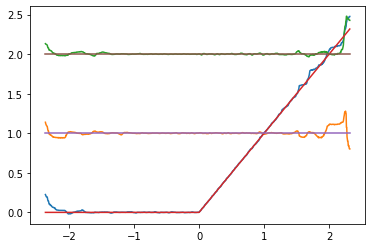

In [4]:
import matplotlib.pyplot as plt
pred_test_point = est.predict(X_test)
plt.plot(X_test[:, 0], pred_test_point)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

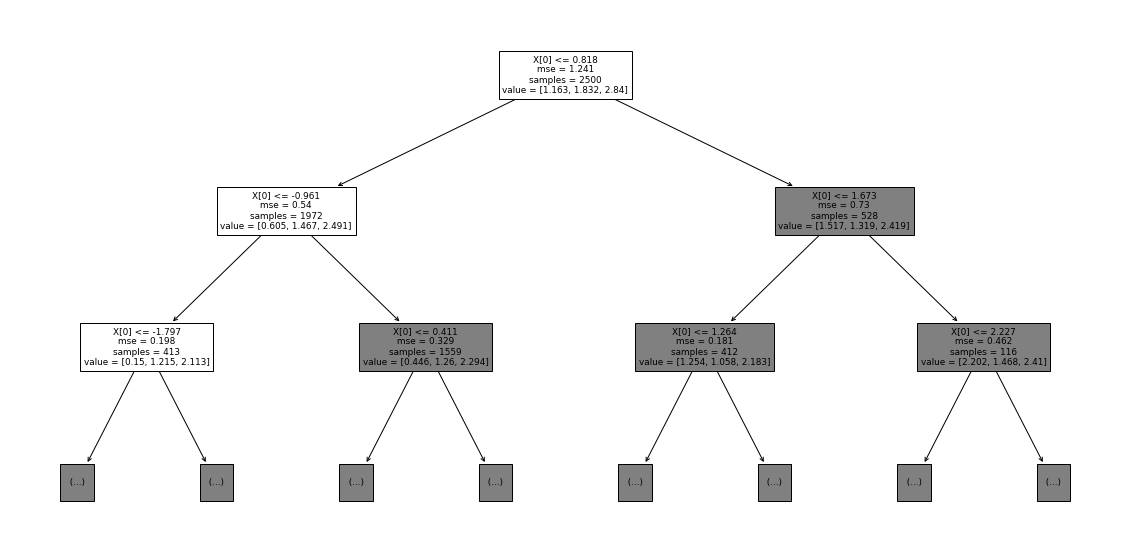

In [5]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

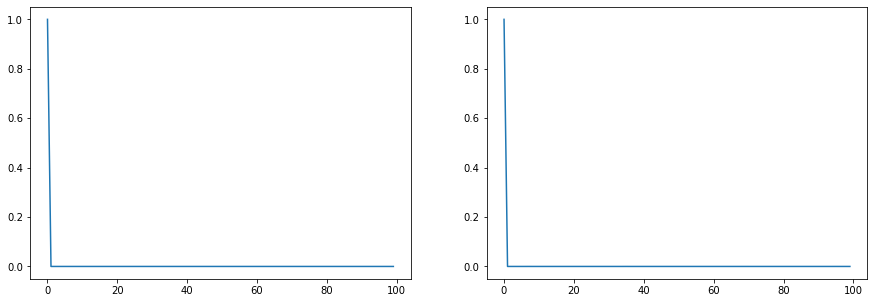

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [7]:
est.decision_path(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


(<1x14914 sparse matrix of type '<class 'numpy.int64'>'
 	with 548 stored elements in Compressed Sparse Row format>,
 array([    0,   145,   288,   431,   588,   739,   884,  1031,  1186,
         1335,  1480,  1627,  1778,  1927,  2076,  2223,  2368,  2517,
         2668,  2815,  2962,  3115,  3266,  3411,  3558,  3709,  3864,
         4013,  4166,  4319,  4468,  4615,  4760,  4911,  5064,  5211,
         5362,  5511,  5660,  5807,  5958,  6109,  6258,  6405,  6554,
         6701,  6856,  6999,  7152,  7305,  7450,  7599,  7746,  7895,
         8046,  8197,  8344,  8489,  8638,  8787,  8932,  9081,  9230,
         9377,  9526,  9671,  9822,  9971, 10120, 10265, 10412, 10565,
        10720, 10871, 11030, 11181, 11328, 11475, 11628, 11783, 11928,
        12083, 12234, 12385, 12528, 12677, 12822, 12973, 13122, 13265,
        13416, 13563, 13708, 13855, 14008, 14159, 14308, 14465, 14616,
        14767, 14914], dtype=int32))

In [8]:
est.apply(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[4, 6, 4, 6, 6, 5, 4, 4, 6, 4, 4, 4, 7, 4, 4, 5, 6, 4, 6, 6, 4, 4,
        6, 4, 4, 4, 6, 4, 6, 4, 4, 6, 6, 4, 4, 4, 6, 6, 6, 4, 5, 4, 4, 6,
        6, 6, 4, 4, 4, 6, 4, 6, 6, 6, 6, 4, 6, 4, 6, 6, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 6, 4, 4, 4, 6, 4, 4, 6, 4, 6, 6, 5, 6, 6, 6, 4, 6, 6, 5,
        6, 4, 6, 4, 5, 4, 4, 4, 6, 4, 6, 4]], dtype=int64)

# IV Causal Forest

In [9]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 1000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [10]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=1000, min_samples_leaf=20,
                   min_impurity_decrease = 0, max_samples=.9,
                   honest=True, verbose=1, n_jobs=-1, random_state=123)

In [11]:
est.fit(X, T, y, Z=Z)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: A column-vector T was passed when a 1d array was expected. Please change the shape of T to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\econml\grf\_forest_classes.py:273: UserWarning: A column-vector Z was passed when a 1d array was expected. Please change the shape of Z to (n_samples,), for example using ravel().
  alpha = self.get_alpha(X, Taug, y, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(

CausalIVForest(min_impurity_decrease=0, min_samples_leaf=20, n_estimators=1000,
               n_jobs=-1, random_state=123, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


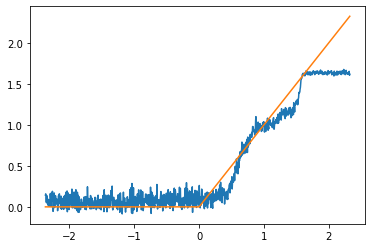

In [12]:
import matplotlib.pyplot as plt
pred_test_point = est.predict(X_test)
plt.plot(X_test[:, 0], pred_test_point)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

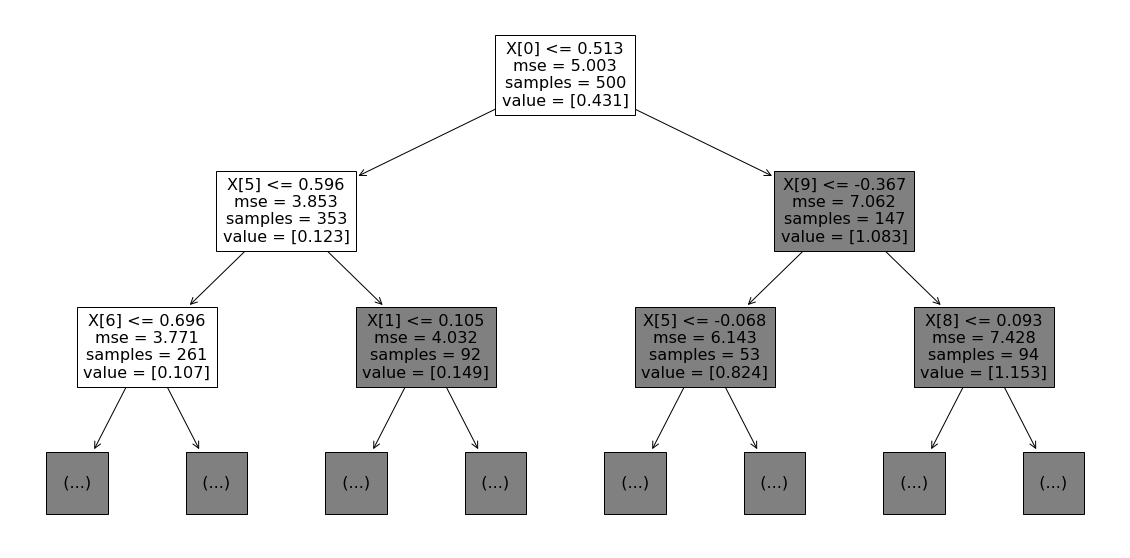

In [13]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

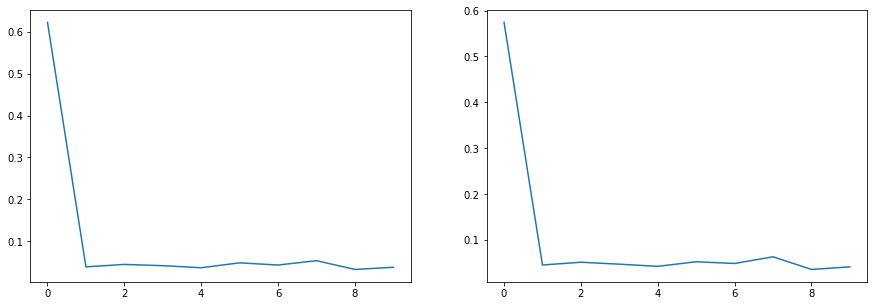

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [15]:
est[0].decision_path(X_test[:1])

<1x29 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [16]:
est[0].apply(X_test[:1])

array([15], dtype=int64)